In [39]:
import numpy as np
from gaussian_process import GaussianProcess, matern52_kernel, rbf_kernel
from bayes_opt import BayesianOptimisation, expected_improvement
from samplers import gaussian_sampling
from objectives import log_likelihood
import matplotlib.pyplot as plt
from parameter_estimation import estimate_params
from lensmodel import mean_function_theta, noisy_data_calc
from packages.utils import read_and_convert, plot_final_params
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

In [2]:
sns.set_theme(style="white", context="paper")
plt.rcParams.update(
    {
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 10,
        "figure.dpi": 300,
        "savefig.format": "png",
        "figure.figsize": (6, 4),
    }
)

In [13]:
# read GAIA parameters

params_df = pd.read_csv(
    "parameter_list.txt", delimiter="\s", names=["t_E", "u_min", "t_0"], header=None
)

params_df = params_df.head(5).copy()

/var/folders/dj/0r5cvjdd4_93c83t_7cz_zp40000gp/T/ipykernel_84764/179284875.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  params_df = pd.read_csv(


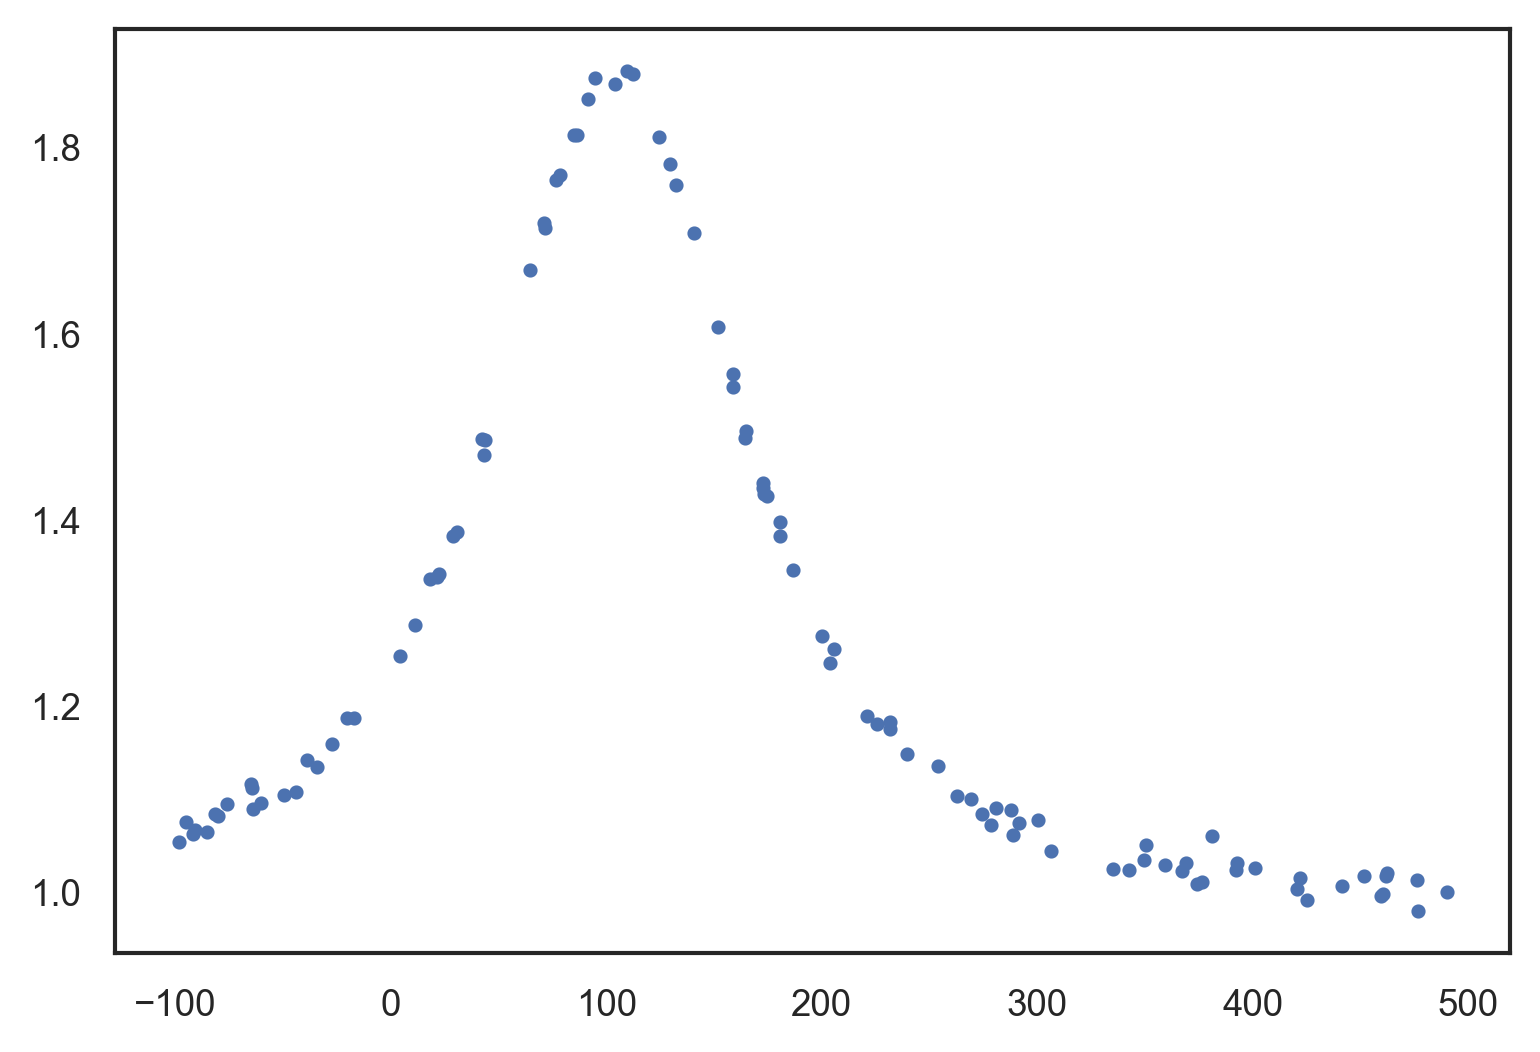

In [35]:
truevalues = [105, 0.6, 2643]
time, mags = noisy_data_calc(-100, 500, truevalues, 0.01, 101, 105)
plt.plot(time, mags, ".")

In [48]:
# for each colum in the dataframe, we will first generate simulated data,
# then apply the BO pipeline on the simulated data to estimate the parameters

for i in tqdm(range(len(params_df))):
    print("running for ", i)
    # for i in tqdm(range(1)):
    t_E = params_df.iloc[i]["t_E"]
    u_min = params_df.iloc[i]["u_min"]
    t_0 = params_df.iloc[i]["t_0"]
    truevalues = [t_E, u_min, t_0]

    # generate simulated data
    time, mags = noisy_data_calc(t_0 - 120, t_0 + 120, truevalues, 0.1, 101, t_0=t_0)
    mags_error = np.ones_like(mags) * 0.05
    observed_times, magnifications, magnification_errors = time, mags, mags_error
    # run BO pipeline

    parameter_bounds = {
        "t_E": [0.01, 700],  # days
        "t_0": [-5, 5],  # days (placeholder, updated in the code)
        "u_min": [0, 4],  # unitless
    }
    bounds = parameter_bounds
    mean_function = None
    sigma = 1

    bounds["t_0"] = [
        np.min(observed_times),
        np.max(observed_times),
    ]  # Change bounds on t_0 before estimating

    # Estimate parameters using bootstrapping
    t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
        observed_times, magnifications, bounds, magnification_errors
    )

    print(
        "Initial predictions:\n"
        f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
        f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
        f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
    )

    # Changes bounds to take into account predictions
    bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
    bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
    bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

    parameter_samples = []

    # Run the Bayesian optimisation 10 times to get a distribution of the best parameters
    for i in tqdm(range(10), desc="Processing"):
        # Define surrogate Gaussian process
        gp = GaussianProcess(kernel=matern52_kernel, sigma_l=1, sigma_f=1)

        # Define Bayesian optimisation
        optimiser = BayesianOptimisation(
            surrogate=gp,
            acquisition=expected_improvement,
            objective=log_likelihood,
            bounds=parameter_bounds,
            sampler=gaussian_sampling,
        )

        optimiser.mag_err = magnification_errors

        # Fit for parameters using the defined Bayesian optimiser
        optimiser.fit(observed_times, magnifications, 100)

        # Plot regret and results
        # optimiser.regret_plot()
        # optimiser.plot_best_param()

        # Append found parameters to the list of all predictions
        parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])
        params = optimiser.x_samples[optimiser.current_best_index]

        # plot the best fit
        time_array = np.linspace(np.min(observed_times), np.max(observed_times), 1000)
        theta = [params[0], params[2]]
        mags = mean_function_theta(time_array, theta, params[1])
        # plt.plot(time_array, mags, color="orange", alpha=0.7)

    # # Plot the observed data on top of the best fit
    # plt.plot(observed_times, magnifications, "k.", label="Observed data")
    # plt.xlabel("Time / Heliocentric Julian Days")
    # plt.ylabel("Magnification")
    # # plt.savefig(f"plots/best_fit_overlap{kernel, sigma_l, datafile}.png", dpi=300)
    # plt.show()

    # Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
    best_parameters = np.mean(parameter_samples, axis=0)
    best_parameter_errors = np.std(parameter_samples, axis=0)

    print(
        "Final predictions:\n"
        f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
        f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
        f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
    )

    print(
        "true value:\n"
        f"    t_0: {truevalues[2]}\n"
        f"    u_min: {truevalues[1]} \n"
        f"    t_E: {best_parameters[0]}"
    )

    # plot_final_params(
    # observed_times, magnifications, best_parameters, mags_error=mags_error)

  0%|          | 0/5 [00:00<?, ?it/s]

running for  0
Initial predictions:
    t_0: 2637.220593925888 ± 0.9408945845088272
    u_min: 0.5005836529853206 ± 0.07449062971866884
    t_E: 86.4285528887918 ± 28.298950127803618


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Final predictions:
    t_0: 2637.6411370623014 ± 0.7429176152802055
    u_min: 0.5739211630016283 ± 0.006617796112775796
    t_E: 106.10642093993602 ± 3.4394893777284055
true value:
    t_0: 2643.087708
    u_min: 0.588895813 
    t_E: 106.10642093993602
running for  1
Initial predictions:
    t_0: 2206.6680586494354 ± 1.6341797216012728
    u_min: 0.6432934019454181 ± 0.20560291419516344
    t_E: 54.63050145741023 ± 23.16342741735102


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Final predictions:
    t_0: 2205.4058738537146 ± 1.157786923423727
    u_min: 0.745341219254019 ± 0.0173764517400305
    t_E: 61.48180360948288 ± 3.40198173373646
true value:
    t_0: 2197.721736
    u_min: 0.738230515 
    t_E: 61.48180360948288
running for  2
Initial predictions:
    t_0: 2240.0948179799907 ± 2.2808580469409487
    u_min: 0.1964731942983392 ± 0.015154265816440048
    t_E: 61.86105626688772 ± 12.640220893431179


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Final predictions:
    t_0: 2241.0942379695675 ± 0.5523074977327114
    u_min: 0.1996612699225829 ± 0.0037635591325289233
    t_E: 60.102703649665536 ± 1.3683668688533959
true value:
    t_0: 2241.026977
    u_min: 0.201540556 
    t_E: 60.102703649665536
running for  3
Initial predictions:
    t_0: 2233.2795400739533 ± 2.81393049607353
    u_min: 0.9010615320930159 ± 0.4751531228336583
    t_E: 43.342332003642 ± 29.03071969975976


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Final predictions:
    t_0: 2235.291455673485 ± 1.771047444549483
    u_min: 1.1245165503027985 ± 0.030669002411860196
    t_E: 47.68384717279529 ± 2.893873806903822
true value:
    t_0: 2237.518976
    u_min: 1.156584206 
    t_E: 47.68384717279529
running for  4
Initial predictions:
    t_0: 2601.6694160766147 ± 0.9371516398016176
    u_min: 0.2480781571858276 ± 0.01216350445694882
    t_E: 128.41693437151758 ± 73.7300652527477


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Final predictions:
    t_0: 2602.679086830155 ± 0.4865196619567768
    u_min: 0.249129121804209 ± 0.003126697488590648
    t_E: 121.95677469255789 ± 3.5325413752555974
true value:
    t_0: 2604.113253
    u_min: 0.253936478 
    t_E: 121.95677469255789


Initial predictions:
    t_0: 2627.511810790026 ± 0.8311917024610824
    u_min: 0.5527974930882551 ± 0.06929996518147001
    t_E: 90.29478469224054 ± 47.094846793354606


Processing: 100%|██████████| 3/3 [01:10<00:00, 23.66s/it]


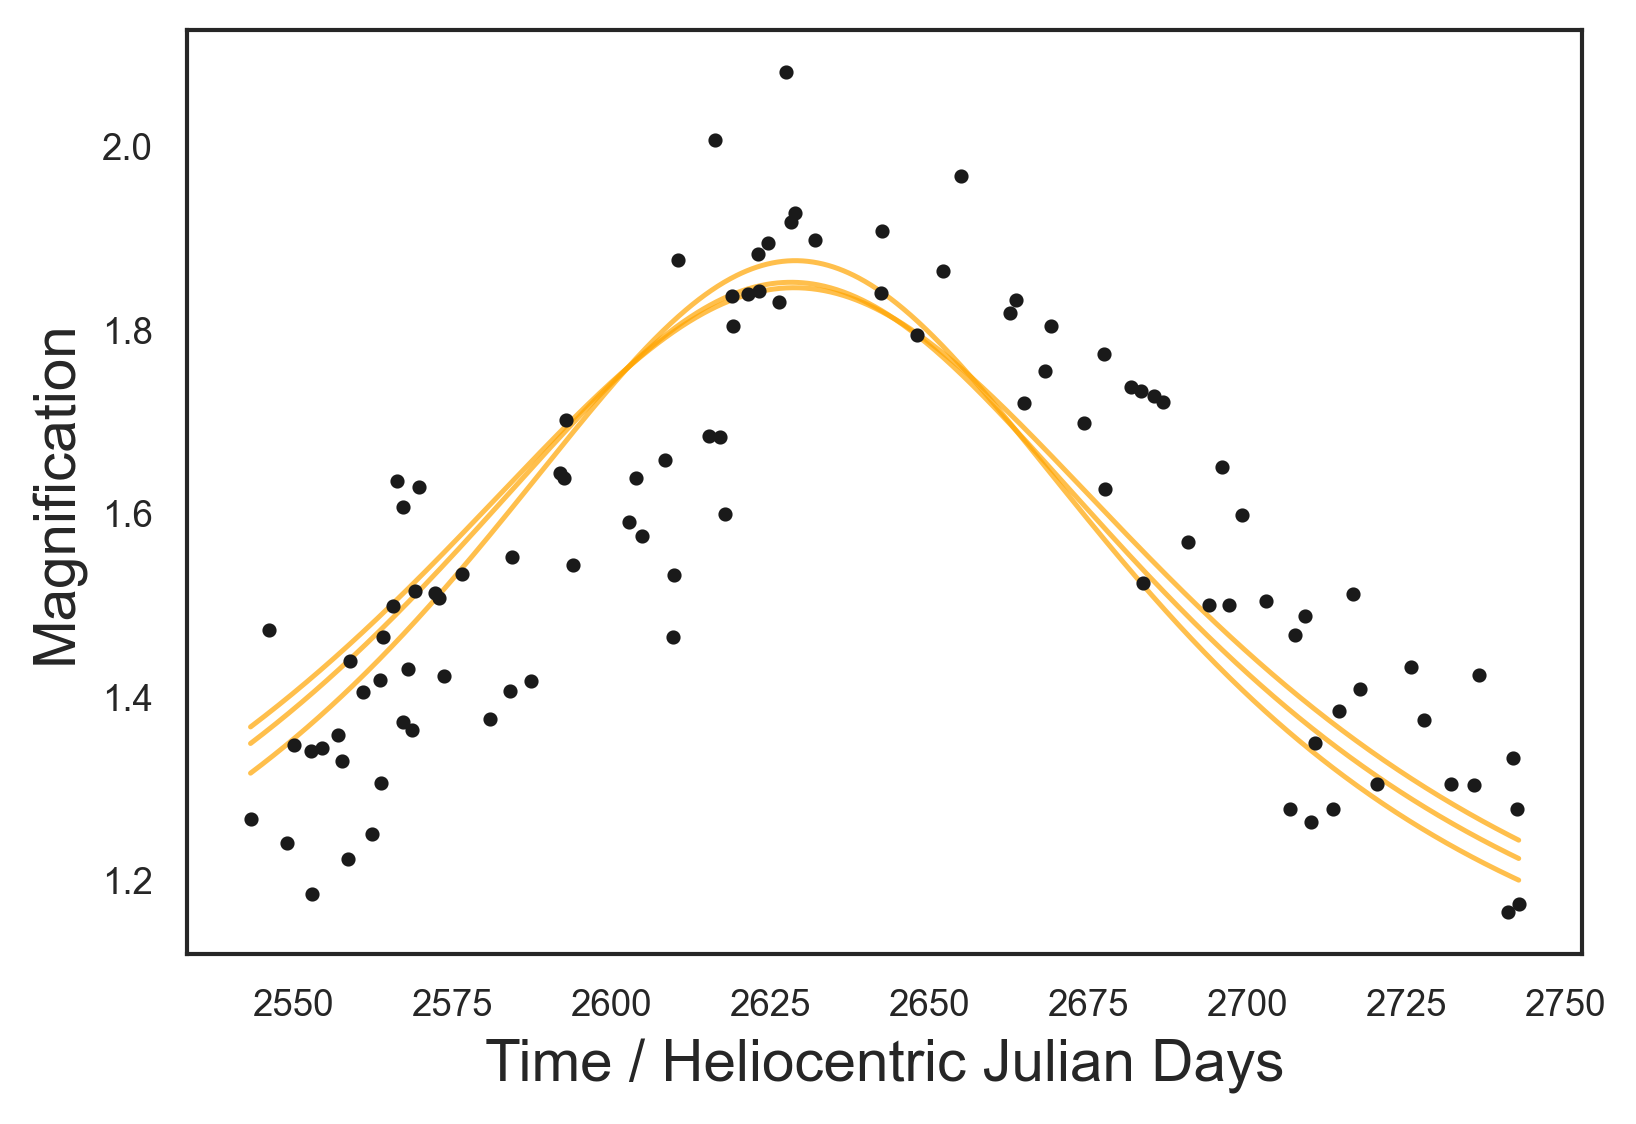

Final predictions:
    t_0: 2628.604826040621 ± 0.27656747452617303
    u_min: 0.610971444402933 ± 0.005402113850361704
    t_E: 108.62662956858206 ± 5.422026011282928


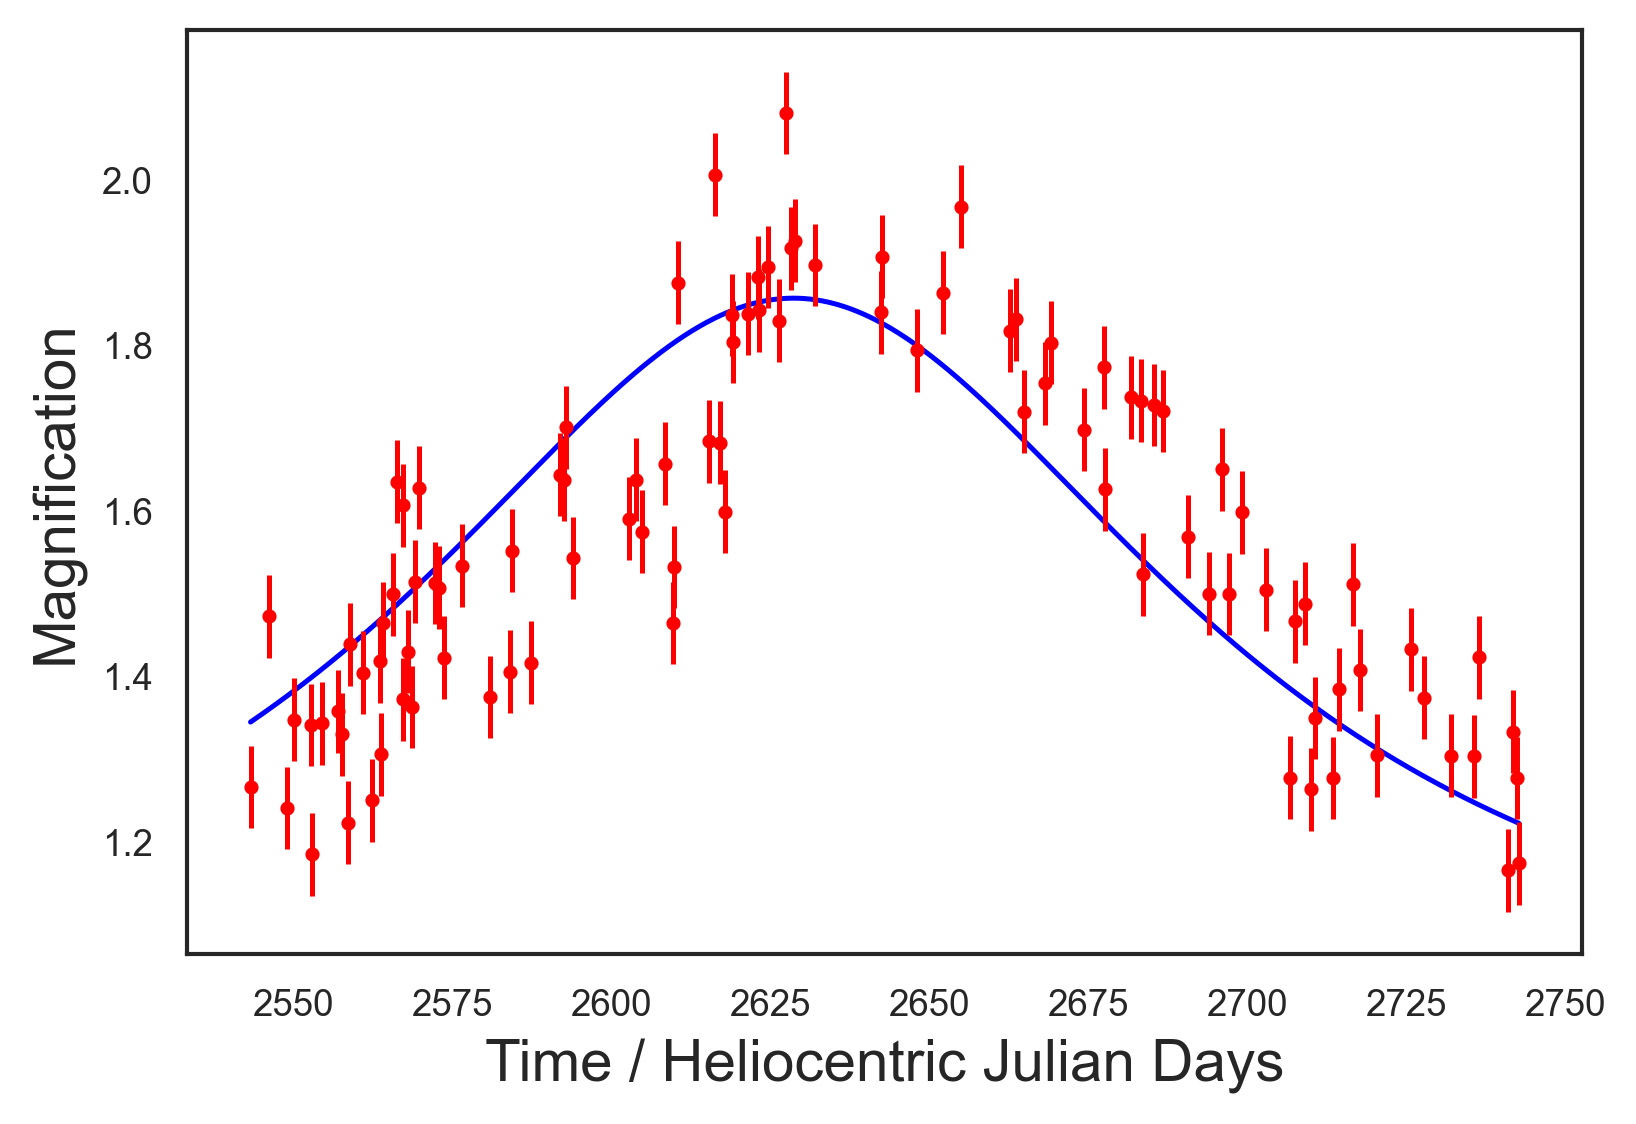

In [38]:
# for each colum in the dataframe, we will first generate simulated data,
# then apply the BO pipeline on the simulated data to estimate the parameters


t_E = params_df.iloc[0]["t_E"]
u_min = params_df.iloc[0]["u_min"]
t_0 = params_df.iloc[0]["t_0"]
truevalues = [t_E, u_min, t_0]

# generate simulated data
time, mags = noisy_data_calc(t_0 - 100, t_0 + 100, truevalues, 0.1, 101, t_0=t_0)
mags_error = np.ones_like(mags) * 0.05
observed_times, magnifications, magnification_errors = time, mags, mags_error
# run BO pipeline

parameter_bounds = {
    "t_E": [0.01, 700],  # days
    "t_0": [-5, 5],  # days (placeholder, updated in the code)
    "u_min": [0, 4],  # unitless
}
bounds = parameter_bounds
mean_function = None
sigma = 1

bounds["t_0"] = [
    np.min(observed_times),
    np.max(observed_times),
]  # Change bounds on t_0 before estimating

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
    observed_times, magnifications, bounds, magnification_errors
)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

parameter_samples = []

# Run the Bayesian optimisation 10 times to get a distribution of the best parameters
for i in tqdm(range(3), desc="Processing"):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=matern52_kernel, sigma_l=1, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(
        surrogate=gp,
        acquisition=expected_improvement,
        objective=log_likelihood,
        bounds=parameter_bounds,
        sampler=gaussian_sampling,
    )

    optimiser.mag_err = magnification_errors

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 400)

    # Plot regret and results
    # optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])
    params = optimiser.x_samples[optimiser.current_best_index]

    # plot the best fit
    time_array = np.linspace(np.min(observed_times), np.max(observed_times), 1000)
    theta = [params[0], params[2]]
    mags = mean_function_theta(time_array, theta, params[1])
    plt.plot(time_array, mags, color="orange", alpha=0.7)

# Plot the observed data on top of the best fit
plt.plot(observed_times, magnifications, "k.", label="Observed data")
plt.xlabel("Time / Heliocentric Julian Days")
plt.ylabel("Magnification")
# plt.savefig(f"plots/best_fit_overlap{kernel, sigma_l, datafile}.png", dpi=300)
plt.show()

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)

plot_final_params(
    observed_times, magnifications, best_parameters, mags_error=mags_error
)

In [32]:
t_E = params_df.iloc[0]["t_E"]
u_min = params_df.iloc[0]["u_min"]
t_0 = params_df.iloc[0]["t_0"]
print(t_E, u_min, t_0)

105.86214 0.588895813 2643.087708
